In [1]:
!pip install emoji
!pip install transformers --upgrade
!pip install torch
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import emoji
import tensorflow as tf

In [113]:
# loading the dataset
df = pd.read_csv('/content/final_hateXplain.csv.zip')

In [114]:
df.columns

Index(['comment', 'label', 'Race', 'Religion', 'Gender', 'Sexual Orientation',
       'Miscellaneous'],
      dtype='object')

In [115]:
# function to check if a string contains any emoji
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in str(text))

# keep only rows with at least one emoji in the comment
df = df[df['comment'].apply(contains_emoji)].reset_index(drop=True)

print("Filtered dataset shape (with emojis only):", df.shape)

Filtered dataset shape (with emojis only): (1491, 7)


In [116]:
df

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
2,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
3,<number> i hope they are not blaming the raghe...,hatespeech,Arab,Nonreligious,Women,No_orientation,NaN
4,<number> mosques in the uk preaching hate to i...,hatespeech,Indian,Islam,No_gender,No_orientation,NaN
...,...,...,...,...,...,...,...
1486,😂 😂 😂 😂 😂 y ’ all be so mad at caucasians fail...,offensive,African,Nonreligious,No_gender,No_orientation,NaN
1487,🤔 🤔 🤔 🤔 mmm yes the trebuchet memes are much n...,hatespeech,Arab,Islam,No_gender,No_orientation,NaN
1488,🤣 this so ghetto i ’ m ready to get tf,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
1489,🤣 🤣 😂 😂 🤣 🤣 😂 😂 🤣 🤣 you spelled my name wrong ...,hatespeech,Arab,Nonreligious,No_gender,No_orientation,NaN


In [117]:
df.isna().sum()

,0
comment,0
label,0
Race,0
Religion,0
Gender,0
Sexual Orientation,0
Miscellaneous,1303


In [118]:
# dropping the 'Miscellaneous' column because it contains mostly missing values (1303 Nans out of 1491 rows)
# and it is not directly relevant to our goal of classifying hate speech based on the text and emoji content
df = df.drop(columns=['Miscellaneous'])
df.describe(include='all')

,comment,label,Race,Religion,Gender,Sexual Orientation
count,1491,1491,1491,1491,1491,1491
unique,1491,3,8,6,3,3
top,🤨 hm six million but yep they were disarmed ce...,normal,No_race,Nonreligious,No_gender,No_orientation
freq,1,796,1088,1336,1194,1342


In [119]:
df.shape

(1491, 6)

<ipython-input-120-f2df532c59f5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')


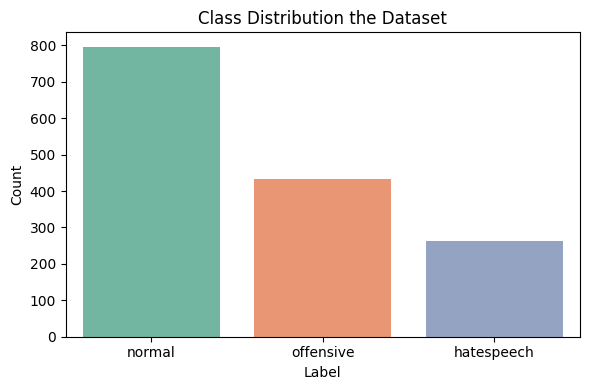

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# plotting the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

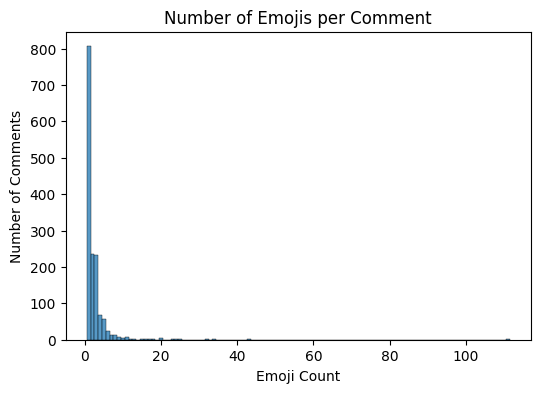

In [121]:
def count_emojis(text):
  return sum(1 for char in text if char in emoji.EMOJI_DATA)

# count the number of emojis in each comment
df['emoji_count'] = df['comment'].apply(count_emojis)

# plot the distribution
import seaborn as sns
plt.figure(figsize=(6,4))
sns.histplot(df['emoji_count'], bins=range(1, df['emoji_count'].max()+2), discrete=True)
plt.title('Number of Emojis per Comment')
plt.xlabel('Emoji Count')
plt.ylabel('Number of Comments')
plt.show()

In [122]:
from sklearn.model_selection import train_test_split

# splitting the dataset into training and testing sets (80% train, 20% test)
# we use stratify to keep class proportions balanced in both sets

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [123]:
from sklearn.preprocessing import LabelEncoder

# initialize label encoder
label_encoder = LabelEncoder()

# fit on training labels only to avoid data leakage
train_labels_encoded = label_encoder.fit_transform(train_df['label'])
test_labels_encoded = label_encoder.transform(test_df['label'])

### Pre-Processing Text

In [124]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [179]:
# simplified preprocessing (preserves punctuation and stopwords for BERT)
def preprocess_text(text):
  return text.lower()

# simplifying repeated emoji descriptions
from collections import Counter
import emoji

def emoji2desc_dedup(text):
  def simplify(data_dict):
    desc = ' '.join(data_dict['en'].split('_')).strip(':')
    return desc
  desc_text = emoji.replace_emoji(text, replace=lambda chars, data_dict: simplify(data_dict))
  tokens = desc_text.split()
  deduped_tokens = [word for word, _ in Counter(tokens).items()]
  return ' '.join(deduped_tokens)

# function to remove emojis entirely from the text-only model
def remove_emojis(text):
  return emoji.replace_emoji(text, replace='')

In [180]:
# for the text-only model
train_text_no_emojis = train_df['comment'].apply(remove_emojis).apply(preprocess_text)
test_text_no_emojis = test_df['comment'].apply(remove_emojis).apply(preprocess_text)

# for the text + emoji model (convert emojis to text before preprocessing)
train_text_with_emojis = train_df['comment'].apply(emoji2desc_dedup).apply(preprocess_text)
test_text_with_emojis = test_df['comment'].apply(emoji2desc_dedup).apply(preprocess_text)

### Tokenizing the Input

In [181]:
from transformers import BertTokenizer

# load pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize text-only data
encoded_train_text_no_emojis = tokenizer(train_text_no_emojis.tolist(), padding=True, truncation=True, return_tensors='pt')

encoded_test_text_no_emojis = tokenizer(test_text_no_emojis.tolist(), padding=True, truncation=True, return_tensors='pt')

# tokenize text + emoji-converted data
encoded_train_text_with_emojis = tokenizer(train_text_with_emojis.tolist(), padding=True, truncation=True, return_tensors='pt')

encoded_test_text_with_emojis = tokenizer(test_text_with_emojis.tolist(), padding=True, truncation=True, return_tensors='pt')

### Create Datasets and DataLoaders

In [182]:
from torch.utils.data import Dataset, DataLoader
import torch

# define a custom Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# wrap data for text-only model
train_dataset_no_emojis = HateSpeechDataset(encoded_train_text_no_emojis['input_ids'],
                                      encoded_train_text_no_emojis['attention_mask'],
                                      torch.tensor(train_labels_encoded))
test_dataset_no_emojis = HateSpeechDataset(encoded_test_text_no_emojis['input_ids'],
                                     encoded_test_text_no_emojis['attention_mask'],
                                     torch.tensor(test_labels_encoded))

# wrap data for text + emoji model
train_dataset_with_emojis = HateSpeechDataset(encoded_train_text_with_emojis['input_ids'],
                                        encoded_train_text_with_emojis['attention_mask'],
                                        torch.tensor(train_labels_encoded))
test_dataset_with_emojis = HateSpeechDataset(encoded_test_text_with_emojis['input_ids'],
                                       encoded_test_text_with_emojis['attention_mask'],
                                       torch.tensor(test_labels_encoded))

# create dataloaders
train_loader_no_emojis = DataLoader(train_dataset_no_emojis, batch_size=32, shuffle=True)
test_loader_no_emojis = DataLoader(test_dataset_no_emojis, batch_size=32)

train_loader_with_emojis = DataLoader(train_dataset_with_emojis, batch_size=32, shuffle=True)
test_loader_with_emojis = DataLoader(test_dataset_with_emojis, batch_size=32)

### Training the Models

In [183]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Compute weights: more weight = more importance for rare classes
class_weights = compute_class_weight(class_weight='balanced',
classes=np.unique(train_labels_encoded),
y=train_labels_encoded)

# Convert to torch tensor and move to GPU/CPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [208]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertConfig

In [209]:
config = BertConfig.from_pretrained(
'bert-base-uncased',
num_labels=3,
hidden_dropout_prob=0.3,
attention_probs_dropout_prob=0.3
)

model_no_emojis = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config).to(device)
for param in model_no_emojis.parameters():
  param.requires_grad = True
model_with_emojis = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config).to(device)
for param in model_with_emojis.parameters():
  param.requires_grad = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [210]:
from transformers import get_scheduler
from torch.optim import AdamW

# Optimizers for both models
optimizer_no_emoji = AdamW(model_no_emojis.parameters(), lr=2e-5, eps=1e-8)
optimizer_with_emoji = AdamW(model_with_emojis.parameters(), lr=2e-5, eps=1e-8)

# Total steps
num_epochs = 10
total_steps = num_epochs * len(train_loader_no_emojis)

# Schedulers
scheduler_no_emoji = get_scheduler(
    "linear", optimizer=optimizer_no_emoji, num_warmup_steps=0, num_training_steps=total_steps
)

scheduler_with_emoji = get_scheduler(
    "linear", optimizer=optimizer_with_emoji, num_warmup_steps=0, num_training_steps=total_steps
)


def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, num_epochs=10, model_name="Model"):
    print(f"\n{'='*10} Training {model_name} {'='*10}")
    model.to(device)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_test_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [211]:
# Train the model without emojis
train_losses_no_emoji, train_accs_no_emoji, test_losses_no_emoji, test_accs_no_emoji  = train_model(
    model_no_emojis,
    train_loader_no_emojis,
    test_loader_no_emojis,
    optimizer_no_emoji,
    scheduler_no_emoji,
    criterion,
    device,
    num_epochs=10,
    model_name="Text-Only Model"
)

# Train the model with emoji descriptions
train_losses_with_emoji, train_accs_with_emoji, test_losses_with_emoji, test_accs_with_emoji = train_model(
    model_with_emojis,
    train_loader_with_emojis,
    test_loader_with_emojis,
    optimizer_with_emoji,
    scheduler_with_emoji,
    criterion,
    device,
    num_epochs=10,
    model_name="Text + Emoji Model"
)


========== Training Text-Only Model ==========
Epoch 1/10 | Train Loss: 1.0230 | Train Acc: 0.5109 | Test Loss: 0.9679 | Test Acc: 0.5351
Epoch 2/10 | Train Loss: 0.9913 | Train Acc: 0.5260 | Test Loss: 0.9289 | Test Acc: 0.5953
Epoch 3/10 | Train Loss: 0.9384 | Train Acc: 0.5537 | Test Loss: 0.8783 | Test Acc: 0.5686
Epoch 4/10 | Train Loss: 0.8821 | Train Acc: 0.5965 | Test Loss: 0.8429 | Test Acc: 0.5920
Epoch 5/10 | Train Loss: 0.8287 | Train Acc: 0.6250 | Test Loss: 0.8248 | Test Acc: 0.6087
Epoch 6/10 | Train Loss: 0.7945 | Train Acc: 0.6569 | Test Loss: 0.8543 | Test Acc: 0.5853
Epoch 7/10 | Train Loss: 0.7683 | Train Acc: 0.6661 | Test Loss: 0.8278 | Test Acc: 0.6020
Epoch 8/10 | Train Loss: 0.7016 | Train Acc: 0.7005 | Test Loss: 0.8677 | Test Acc: 0.5853
Epoch 9/10 | Train Loss: 0.6772 | Train Acc: 0.7173 | Test Loss: 0.8553 | Test Acc: 0.6087
Epoch 10/10 | Train Loss: 0.6772 | Train Acc: 0.7232 | Test Loss: 0.8656 | Test Acc: 0.5920

========== Training Text + Emoji Model =

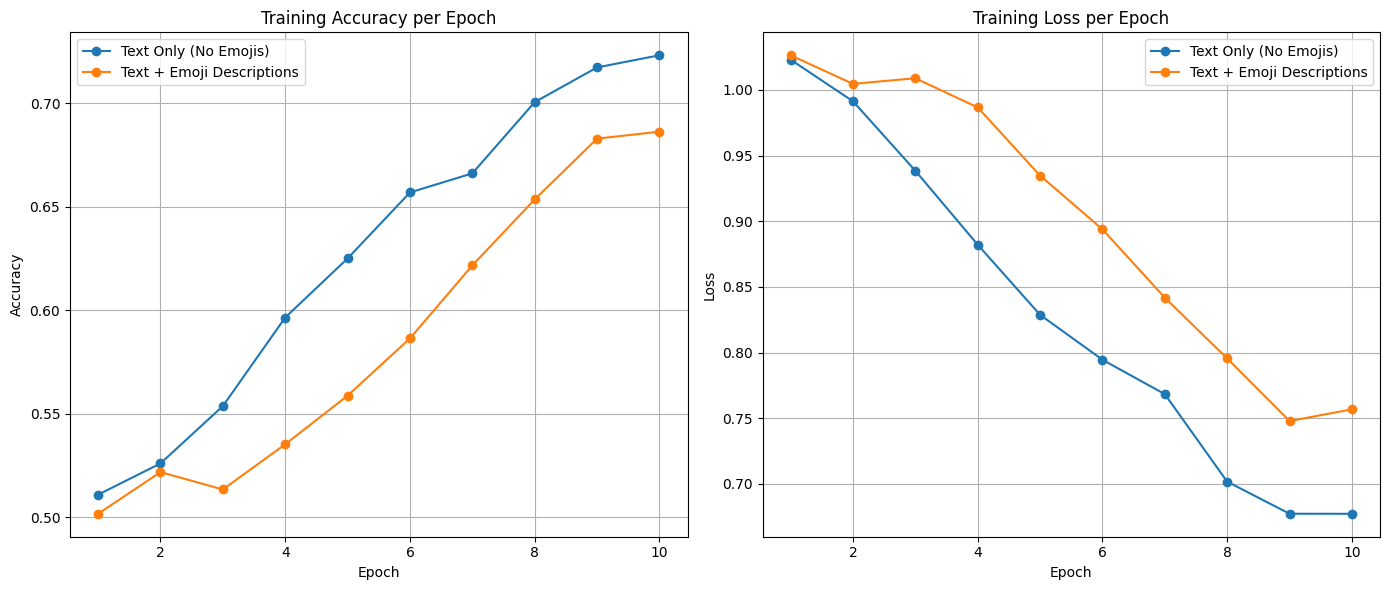

In [212]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_accs_no_emoji) + 1))

# Create the plot
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs_no_emoji, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, train_accs_with_emoji, label='Text + Emoji Descriptions', marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_no_emoji, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, train_losses_with_emoji, label='Text + Emoji Descriptions', marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

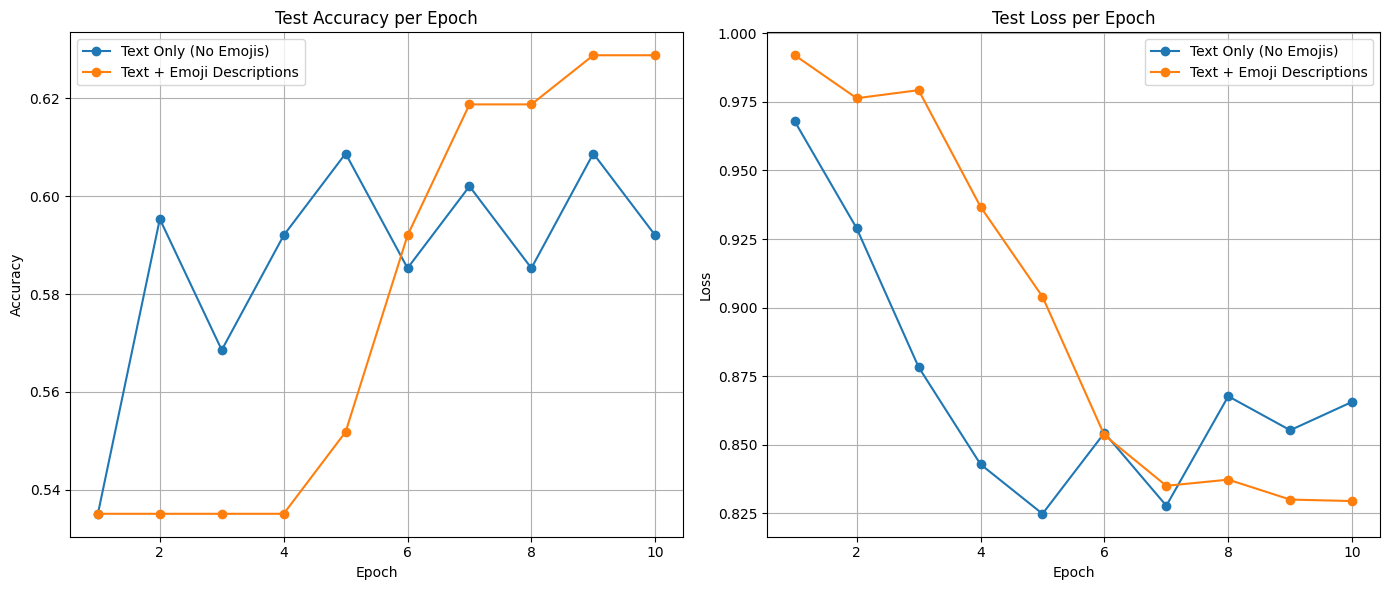

In [213]:
# Create the plot
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, test_accs_no_emoji, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, test_accs_with_emoji, label='Text + Emoji Descriptions', marker='o')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses_no_emoji, label='Text Only (No Emojis)', marker='o')
plt.plot(epochs, test_losses_with_emoji, label='Text + Emoji Descriptions', marker='o')
plt.title('Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [214]:
def get_predictions(model, dataloader, device):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  return all_preds, all_labels

In [215]:
# For text-only model
preds_no_emoji, labels_no_emoji = get_predictions(model_no_emojis, test_loader_no_emojis, device)

# For emoji model
preds_with_emoji, labels_with_emoji = get_predictions(model_with_emojis, test_loader_with_emojis, device)

Text Only Model:
               precision    recall  f1-score   support

      normal       0.51      0.71      0.59        52
   offensive       0.71      0.65      0.68       160
  hatespeech       0.46      0.41      0.43        87

    accuracy                           0.59       299
   macro avg       0.56      0.59      0.57       299
weighted avg       0.60      0.59      0.59       299

Text + Emoji Model:
               precision    recall  f1-score   support

      normal       0.58      0.65      0.61        52
   offensive       0.67      0.79      0.73       160
  hatespeech       0.53      0.31      0.39        87

    accuracy                           0.63       299
   macro avg       0.59      0.59      0.58       299
weighted avg       0.61      0.63      0.61       299



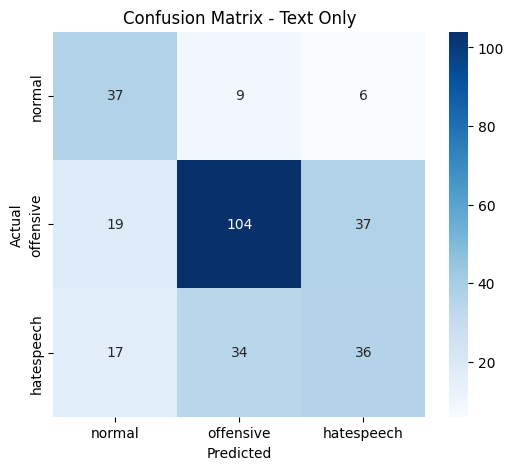

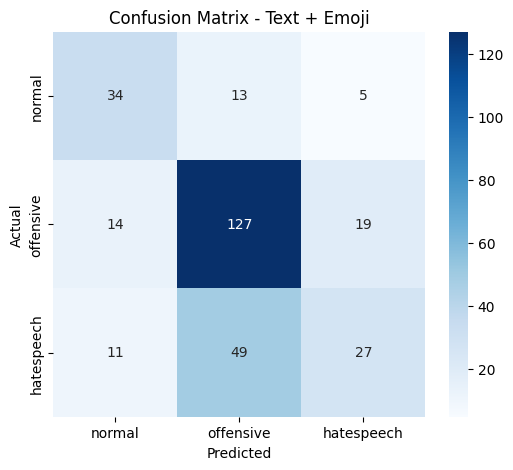

In [217]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Classification report
print("Text Only Model:\n", classification_report(labels_no_emoji, preds_no_emoji, target_names=['normal', 'offensive', 'hatespeech']))
print("Text + Emoji Model:\n", classification_report(labels_with_emoji, preds_with_emoji, target_names=['normal', 'offensive', 'hatespeech']))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal','offensive','hatespeech'], yticklabels=['normal','offensive','hatespeech'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title)
  plt.show()

plot_conf_matrix(labels_no_emoji, preds_no_emoji, "Confusion Matrix - Text Only")
plot_conf_matrix(labels_with_emoji, preds_with_emoji, "Confusion Matrix - Text + Emoji")


### Saving Both BERT Models

In [224]:
# For the model without emojis
torch.save(model_no_emojis.state_dict(), "bert_no_emojis.pt")

# For the model with emojis
torch.save(model_with_emojis.state_dict(), "bert_with_emojis.pt")